In [1]:
import sys
sys.path.append('../src/')
from IPython.display import clear_output
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
import registration as reg
import segmentation as seg
import analysis as ana
import SimpleITK as sitk
import numpy as np
import utils as ut
import importlib

In [19]:
COMMON_PATH = "../data/COMMON_images_masks/common_"
NEW_PATH = "../data/resampled_images_256/"
#NEW_PATH = "../data/resampled_images_256_label1/"
GROUP_PATH = "../data/g3_"

# 1.Data Exploration

In [24]:
importlib.reload(ut)
filename = COMMON_PATH + '40_image.nii.gz'
maskname = COMMON_PATH + '40_mask.nii.gz'
pelvic_img = ut.read_image(filename)
pelvic_mask = ut.read_image(maskname)

In [4]:
sitk.GetArrayFromImage(pelvic_img).shape
pelvic_img.GetSize()

(286, 512, 512)

In [22]:
importlib.reload(ut)
filename = GROUP_PATH + '59_image.nii.gz'
maskname = GROUP_PATH + '59_mask.nii.gz'
pelvic_img = ut.read_image(filename)
pelvic_mask = ut.read_image(maskname)

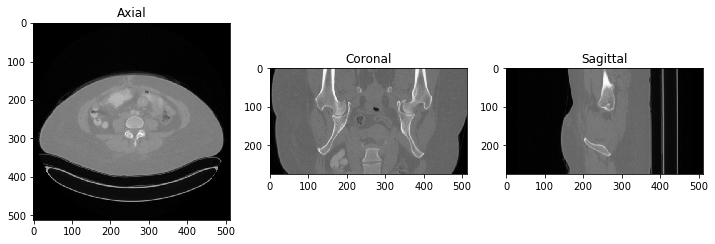

In [6]:
ut.plot_3d_img_slices(pelvic_img)

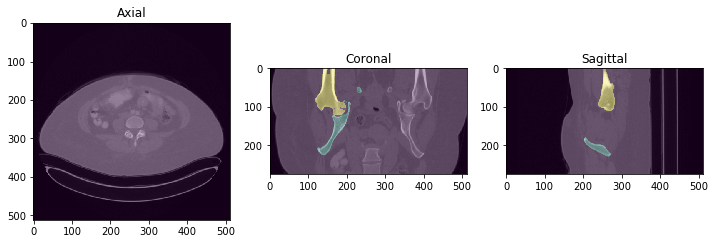

In [7]:
ut.plot_3d_img_masked(pelvic_img, pelvic_mask)

### Select only mask of interest (1 Right femur and 3 Right hip bone)

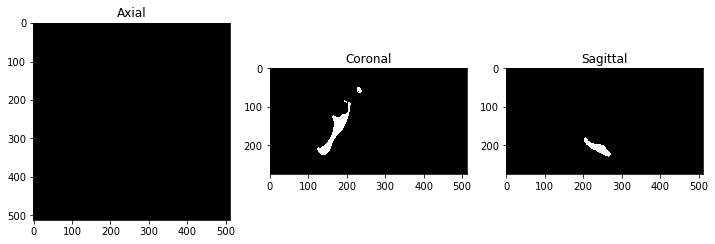

In [23]:
importlib.reload(reg)
mask_of_interest = reg.Transform.create_mask_of_interest(maskname, labels=[1,3], verbose=True)

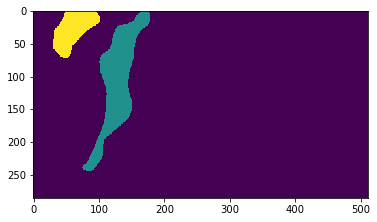

In [28]:
data = sitk.GetArrayFromImage(mask_of_interest)
plt.imshow(data[:,256,:])

## Resampling to the same space

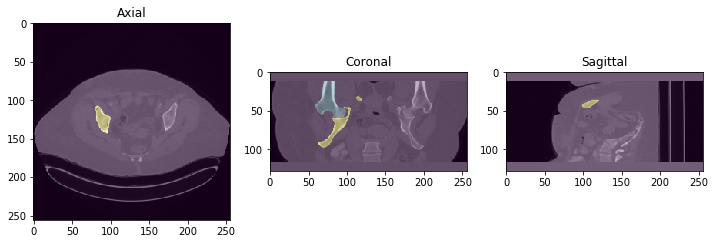

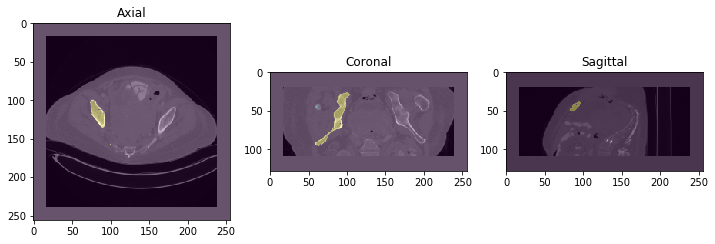

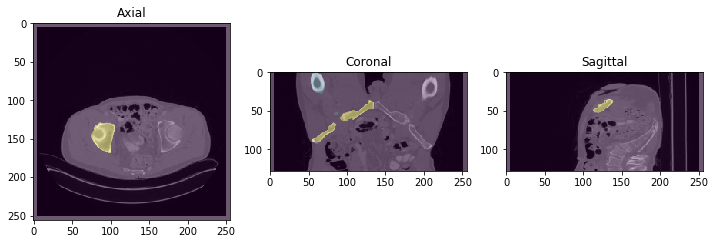

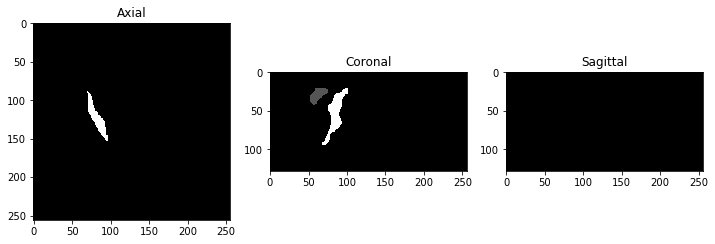

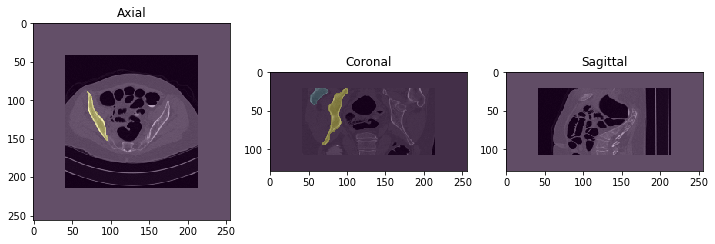

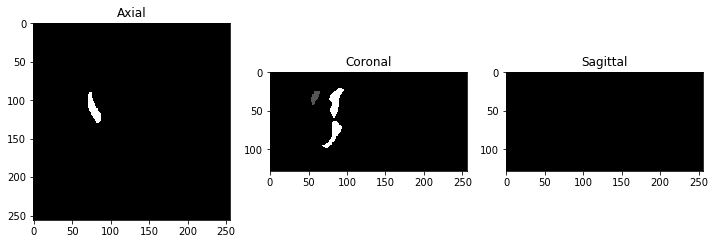

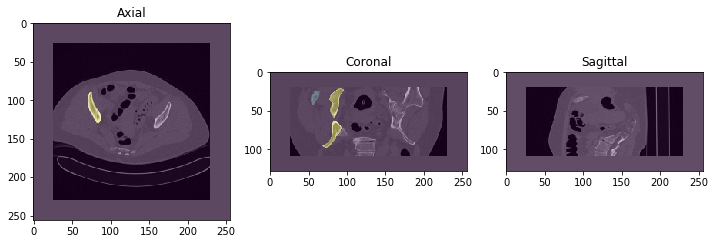

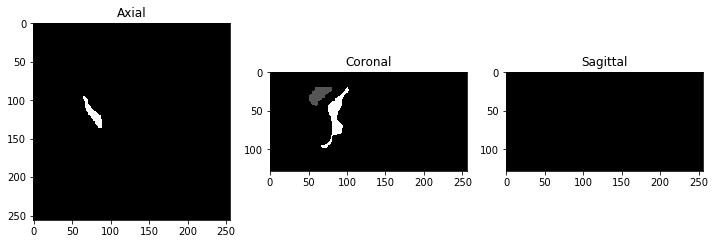

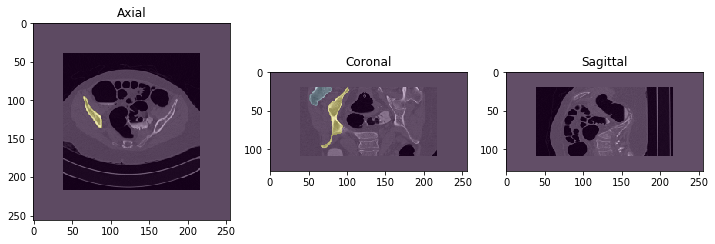

In [42]:
importlib.reload(reg)
importlib.reload(ut)
importlib.reload(seg)

images = []
masks = []
id_name = []
for id in range(59,62):
   filename = GROUP_PATH + '{}_image.nii.gz'.format(id)
   maskname = GROUP_PATH + '{}_mask.nii.gz'.format(id)
   pelvic_img = ut.read_image(filename)
   pelvic_mask = reg.Transform.create_mask_of_interest(maskname, labels=[1,3])
   #pelvic_mask = ut.read_image(maskname)

   images.append(pelvic_img)
   masks.append(pelvic_mask)
   id_name.append(id)

for id in range(40,43):
   filename = COMMON_PATH + '{}_image.nii.gz'.format(id)
   maskname = COMMON_PATH + '{}_mask.nii.gz'.format(id)

   pelvic_img = ut.read_image(filename)
   #pelvic_mask = ut.read_image(maskname)
   pelvic_mask = reg.Transform.create_mask_of_interest(maskname, labels=[1,3])

   images.append(pelvic_img)
   masks.append(pelvic_mask)
   id_name.append(id)

#Resampling the images and masks
[resampled_images, resampled_masks] = ut.resample_all_images(images, masks)


#Displaying and saving the resampled images and masks
for image, mask, id in zip(resampled_images, resampled_masks, id_name):
    #mask = reg.Transform.create_mask_of_interest(mask, labels=[1,3])
    ut.plot_3d_img_masked(image, mask)
    ut.save_image(image, NEW_PATH + "{}_image.nii".format(id))
    ut.save_image(mask, NEW_PATH + "{}_mask.nii".format(id))




## 1.2 Explore a Fixed and Moving Image

In [29]:
fixed_image = ut.read_image(COMMON_PATH + '40_image.nii.gz')
moving_image = ut.read_image(GROUP_PATH + '59_image.nii.gz')

In [30]:
importlib.reload(ut)
interact(ut.display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=142, description='fixed_image_z', max=285), IntSlider(value=137, descrip…

In [31]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image,
                                                      moving_image,
                                                      sitk.Euler3DTransform(),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(ut.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))

interactive(children=(IntSlider(value=142, description='image_z', max=285), FloatSlider(value=0.5, description…

<function utils.display_images_with_alpha(image_z, alpha, fixed, moving)>

# 3. Registration
## Linear Trasform: Affine Transformation 12DOF

In [5]:
im_ref_filename = COMMON_PATH + '40_image.nii.gz'
im_mov_filename = GROUP_PATH + '59_image.nii.gz'

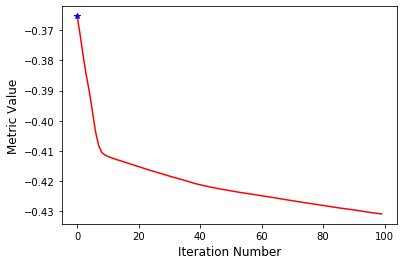

itk::simple::Transform
 AffineTransform (0000019DBEA0B960)
   RTTI typeinfo:   class itk::AffineTransform<double,3>
   Reference Count: 3
   Modified Time: 1516166
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.996394 -0.00424712 -0.00465432 
     -0.019906 1.03542 0.00012776 
     0.000533953 0.010541 0.992076 
   Offset: [8.67958, -17.7248, -171.983]
   Center: [1, -129, 842.698]
   Translation: [5.30167, -22.2061, -180.02]
   Inverse: 
     1.0037 0.00406908 0.00470832 
     0.0192962 0.965872 -3.38574e-05 
     -0.000745234 -0.0102648 1.00798 
   Singular: 0

--------
Final metric value: -0.4308582830729133
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.
--------
Wall time: 1min 9s


In [6]:
%%time
importlib.reload(reg)
lin_trf = reg.LinearTransform(im_ref_filename=im_ref_filename,im_mov_filename=im_mov_filename)
lin_xfm = lin_trf.est_transf(metric="MI", verbose=True)

In [37]:
moving_image = lin_trf.apply_transf(lin_xfm)
fixed_image = lin_trf.im_mov
interact(ut.display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=137, description='fixed_image_z', max=275), IntSlider(value=142, descrip…

In [38]:
fixed_image = lin_trf.im_ref
moving_image = lin_trf.apply_transf(lin_xfm)
interact(ut.display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=142, description='fixed_image_z', max=285), IntSlider(value=142, descrip…

In [21]:
fixed_image = ut.read_image(COMMON_PATH + '40_image.nii.gz')
moving_image = ut.read_image(GROUP_PATH + '59_image.nii.gz')

moving_resampled = sitk.Resample(moving_image, fixed_image, lin_xfm, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
# fixed_image = lin_trf.im_ref
# moving_image = lin_trf.im_mov
# moving_resampled = lin_trf.apply_transf(lin_xfm)

interact(ut.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))

interactive(children=(IntSlider(value=142, description='image_z', max=285), FloatSlider(value=0.5, description…

<function utils.display_images_with_alpha(image_z, alpha, fixed, moving)>

## Non Linear Transformation  FFD

In [17]:
%%time
importlib.reload(reg)
non_lin_trf = reg.NonLinearTransform(im_ref_filename=im_ref_filename, im_mov_filename=im_mov_filename)
non_lin_trf.im_mov = moving_resampled
non_lin_xfm = non_lin_trf.est_transf(metric="SSD")

itk::simple::Transform
 BSplineTransform (000002B4E03CA520)
   RTTI typeinfo:   class itk::BSplineTransform<double,3,3>
   Reference Count: 3
   Modified Time: 3653157
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 000002B4C3210870, 000002B4C3211C20, 000002B4C32132A0 ]
   TransformDomainOrigin: [-169.083, -299.083, 728.2]
   TransformDomainPhysicalDimensions: [340.166, 340.166, 228.997]
   TransformDomainDirection: 1 0 0
0 1 0
0 0 1

   TransformDomainMeshSize: [11, 11, 8]
   GridSize: [14, 14, 11]
   GridOrigin: [-200.007, -330.007, 699.575]
   GridSpacing: [30.9242, 30.9242, 28.6246]
   GridDirection: 1 0 0
0 1 0
0 0 1


--------
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 41.
Number of iterations: 41
--------
Wall time: 9min 35s


In [18]:
fixed_image = ut.read_image(COMMON_PATH + '40_image.nii.gz')
moving_image = ut.read_image(GROUP_PATH + '59_image.nii.gz')

moving_resampled = sitk.Resample(moving_image, fixed_image, non_lin_xfm, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(ut.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))

interactive(children=(IntSlider(value=142, description='image_z', max=285), FloatSlider(value=0.5, description…

<function utils.display_images_with_alpha(image_z, alpha, fixed, moving)>

# Atlas Segmentation

In [5]:
importlib.reload(seg)
importlib.reload(reg)
atlas_seg = seg.AtlasSegmentation()

../data/resampled_images_256/59_image.nii
../data/resampled_images_256/60_image.nii
../data/resampled_images_256/61_image.nii


In [8]:
atlas_seg.cmn_mask
atlas_seg.grp_mask

{59: <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000019DF6FE78D0> >,
 60: <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000019DF6FE7E10> >,
 61: <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000019DF6FE7BA0> >}

In [18]:
print("COMMON SPACES")
for id in atlas_seg.cmn_mask:
    print(id, "MASK", atlas_seg.cmn_mask[id].GetSize(), "Spacing", atlas_seg.cmn_mask[id].GetSpacing(), "Origin", atlas_seg.cmn_mask[id].GetOrigin())
    print(id, "IMG", atlas_seg.cmn_img[id].GetSize(), "Spacing", atlas_seg.cmn_img[id].GetSpacing(), "Origin", atlas_seg.cmn_img[id].GetOrigin())

print("GROUPE SPACES")
for id in atlas_seg.grp_mask:
        print(id, "Size", atlas_seg.grp_mask[id].GetSize(), "Spacing", atlas_seg.grp_mask[id].GetSpacing(), "Origin", atlas_seg.grp_mask[id].GetOrigin())
        print(id, "IMG", atlas_seg.grp_img[id].GetSize(), "Spacing", atlas_seg.grp_img[id].GetSpacing(), "Origin", atlas_seg.grp_img[id].GetOrigin())

COMMON SPACES
40 MASK (512, 512, 286) Spacing (0.6640625, 0.6640625, 0.79998779296875) Origin (-168.66796875, -298.66796875, 728.7000122070312)
40 IMG (512, 512, 286) Spacing (0.6640625, 0.6640625, 0.79998779296875) Origin (-168.66796875, -298.66796875, 728.7000122070312)
41 MASK (512, 512, 300) Spacing (0.78125, 0.78125, 0.800018310546875) Origin (-207.609375, -330.609375, -463.1000061035156)
41 IMG (512, 512, 300) Spacing (0.78125, 0.78125, 0.800018310546875) Origin (-207.609375, -330.609375, -463.1000061035156)
42 MASK (512, 512, 291) Spacing (0.68359375, 0.68359375, 0.79998779296875) Origin (-165.658203125, -299.658203125, -481.0)
42 IMG (512, 512, 291) Spacing (0.68359375, 0.68359375, 0.79998779296875) Origin (-165.658203125, -299.658203125, -481.0)
GROUPE SPACES
59 Size (512, 512, 276) Spacing (0.9765625, 0.9765625, 1.0) Origin (-249.51171875, -400.06170654296875, 525.5)
59 IMG (512, 512, 276) Spacing (0.9765625, 0.9765625, 1.0) Origin (-249.51171875, -400.06170654296875, 525.5)


In [41]:
print("COMMON MASK SPACES")
for id in atlas_seg.cmn_mask:
print("GROUPE MASK SPACES")
for id in atlas_seg.grp_mask:
        print(id, "Size", atlas_seg.grp_mask[id].GetSize(), "Spacing", atlas_seg.grp_mask[id].GetSpacing(), "Origin", atlas_seg.grp_mask[id].GetOrigin())

IndentationError: expected an indented block (<ipython-input-41-b43b7dfe35ee>, line 5)

# Creating and saving atlas segmentations using the group image masks
#Note, I made it so that the atlas segmentation/registration uses masks during the registration.
#Made results slightly better. Only ran it for image 40 so far.

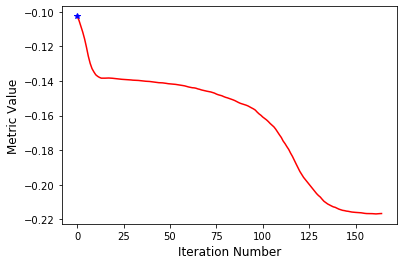

itk::simple::Transform
 AffineTransform (00000250D1DDDBB0)
   RTTI typeinfo:   class itk::AffineTransform<double,3>
   Reference Count: 3
   Modified Time: 2232379
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.950296 -0.000958198 0.00436544 
     -0.00519808 0.799038 0.00132645 
     0.00657187 0.000813992 0.972945 
   Offset: [13.69, 91.6873, 2.57621]
   Center: [249.512, 249.512, 169.5]
   Translation: [1.78915, 40.4729, -0.166693]
   Inverse: 
     1.05234 0.00126677 -0.00472342 
     0.00685775 1.25151 -0.001737 
     -0.00711391 -0.00105561 1.02784 
   Singular: 0

--------
Final metric value: -0.21663128548583077
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 165.
--------


In [43]:
importlib.reload(ut)
importlib.reload(reg)
importlib.reload(seg)
atlas_seg = seg.AtlasSegmentation()

cmn_40_seg_saved = atlas_seg.seg_atlas(40)
ut.save_image(sitk.GetImageFromArray(cmn_40_seg_saved), "../data/Atlas_segmentations/{}_atlas_seg.nii".format(40))
np.save("../data/Atlas_segmentations/{}_atlas_seg.npy".format(40),cmn_40_seg_saved)

In [25]:
cmn_41_seg_saved = atlas_seg.seg_atlas(41)
ut.save_image(sitk.GetImageFromArray(cmn_41_seg_saved), "../data/Atlas_segmentations/{}_atlas_seg.nii".format(41))
np.save("../data/Atlas_segmentations/{}_atlas_seg.npy".format(41),cmn_41_seg_saved)

In [26]:
cmn_42_seg_saved = atlas_seg.seg_atlas(42)
ut.save_image(sitk.GetImageFromArray(cmn_42_seg_saved), "../data/Atlas_segmentations/{}_atlas_seg.nii".format(42))
np.save("../data/Atlas_segmentations/{}_atlas_seg.npy".format(42),cmn_42_seg_saved)

# Looking at the atlases made for the 3 common images

Image : 40
Atlas mask


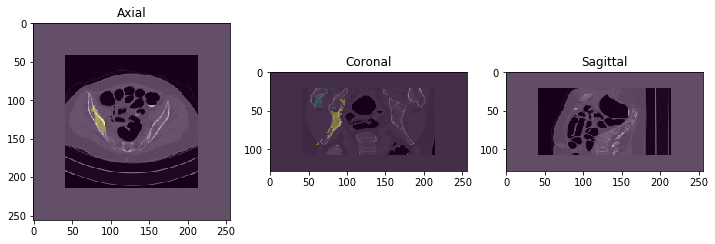

Reference mask


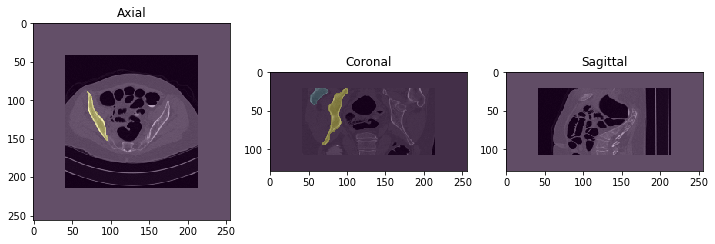

In [44]:
importlib.reload(seg)
importlib.reload(reg)
importlib.reload(ut)
for image_id in range(40,43):
    print("Image : {}".format(image_id))

    print("Atlas mask")
    mask = np.load("../data/Atlas_segmentations/{}_atlas_seg.npy".format(image_id))
    filename = NEW_PATH + '{}_image.nii'.format(image_id)
    image = ut.read_image(filename)
    atlas_mask = sitk.GetImageFromArray(mask)
    ut.plot_3d_img_masked(image, atlas_mask)



    print("Reference mask")
    ref_mask_name = NEW_PATH + '{}_mask.nii'.format(image_id)
    ref_mask = ut.read_image(ref_mask_name)
    #mask_of_interest = reg.Transform.create_mask_of_interest(maskname, labels=[1,3], verbose=False)
    ut.plot_3d_img_masked(image, ref_mask )
    #Note, the reference masks look wrong for image 41 and 42.


# Checking Dice results for the atlas segmentations

# Checking HausDorf Distance for the atlas segmentations

In [45]:
importlib.reload(ut)
importlib.reload(seg)

labels = [1,2, None]

dice_results = []
hdd_results = []
for label_id in labels:
    for image_id in range(40,43):

        mask_name = NEW_PATH + '{}_mask.nii'.format(image_id)
        ref_mask = ut.read_image(mask_name)
        if label_id != None:
            ref_mask  = reg.Transform.create_mask_of_interest2(ref_mask, labels=[label_id], verbose=False)

        test_mask_array = np.load("../data/Atlas_segmentations/{}_atlas_seg.npy".format(image_id))
        test_mask = sitk.GetImageFromArray(test_mask_array)
        if label_id != None:
            test_mask = reg.Transform.create_mask_of_interest2(test_mask, labels=[label_id], verbose=False)

        test_mask = sitk.Cast(test_mask, sitk.sitkInt32)
        ref_mask = sitk.Cast(ref_mask, sitk.sitkInt32)
        dice_results.append(seg.dice_analysis(test_mask, ref_mask))
        hdd_results.append(seg.hausdorf_distance_analysis(test_mask, ref_mask))
        print("Image {} and label {}".format(image_id, label_id))
        print("Dice results = {}".format(seg.dice_analysis(test_mask, ref_mask)))
        print("HausDorf distance = {}".format(seg.hausdorf_distance_analysis(test_mask, ref_mask)))




0.4516640952171038
17.378147196982766
